# **generate stl file**

In [ ]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#create point

class Point:

  def __init__(self, x, y, z):
    self.x = x
    self.y = y
    self.z = z

  def translate(self, dx = 0, dy = 0, dz = 0):
    self.dx = self.x + dx
    self.dy = self.y + dy
    self.dz = self.z + dz

    return Point(self.x, self.dy, self.dz)

  def __repr__(self):
    return f"Point(x = {self.x}, y = {self.y}, z = {self.z})"



In [ ]:
#create circle

class Circle:
  def __init__(self, center, radius, num_points):
    self.center = center
    self.radius = radius
    self.num_points = num_points

  def _generate_points(self):
    points = []
    for i in range(self.num_points):
      angle = 2 * math.pi * i / self.num_points   #length of arc = r*theta
      x = self.center.x + self.radius * math.cos(angle)
      y = self.center.y + self.radius * math.sin(angle)
      z = self.center.z
      points.append(Point(x, y, z))
    return points

  def __repr__(self):
    return f"Circle(center = {self.center}, radius = {self.radius}, num_points = {self.num_points})"


In [ ]:
#extrude

def extrude(profile_points, height):
  top_face = [pt.translate(dz = height) for pt in profile_points]
  return profile_points, top_face



In [ ]:
#visualize

def visualize(base, top):

  fig = plt.figure(figsize = (7, 7))
  ax = fig.add_subplot(111, projection = '3d')

  xs = [p.x for p in base] + [base[0].x]
  ys = [p.y for p in base] + [base[0].y]
  zs = [p.z for p in base] + [base[0].z]

  ax.plot(xs, ys, zs, color = 'red')

  xt = [p.x for p in top] + [top[0].x]
  yt = [p.y for p in top] + [top[0].y]
  zt = [p.z for p in top] + [top[0].z]

  ax.plot(xt, yt, zt, color = 'blue')

  for b, t in zip(base, top):
    ax.plot([b.x, t.x], [b.y, t.y], [b.z, t.z], color = 'gray')

  plt.plot(xs, ys, zs, color = 'black') #bottom edge
  plt.plot(xt, yt, zt, color = 'black') #top edge

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title("Extruded Cylinder")
  plt.show()

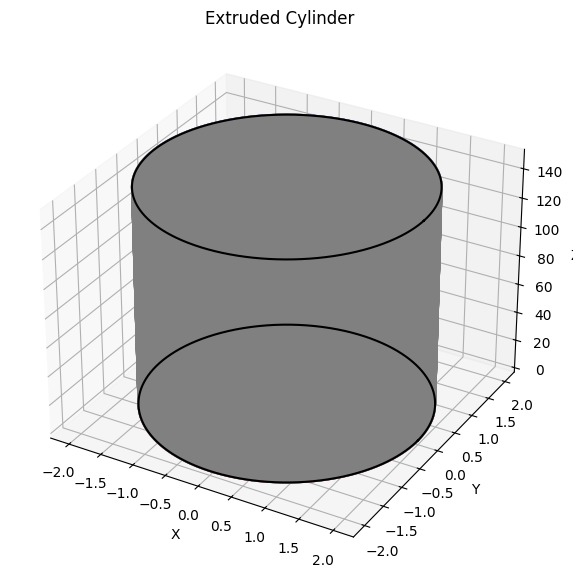

In [ ]:
center = Point(0,0,0)
circle_points = Circle(center, radius = 2, num_points = 1000)._generate_points()
base, top  = extrude(circle_points, height = 150)
visualize(base, top)

# **stl output**

In [ ]:
# Pure-Python STL exporter (ASCII)
import math

def write_ascii_stl_from_extrusion(filename, base, top):
    """
    base, top : lists of Point objects (same length, ordered)
    Writes an ASCII STL representing the extruded surface with caps.
    """

    n = len(base)
    if n != len(top):
        raise ValueError("base and top must have same length")

    # helper to compute normal of triangle (returns unit normal tuple)
    def tri_normal(p1, p2, p3):
        ux, uy, uz = (p2.x - p1.x, p2.y - p1.y, p2.z - p1.z)
        vx, vy, vz = (p3.x - p1.x, p3.y - p1.y, p3.z - p1.z)
        # cross product u x v
        nx = uy * vz - uz * vy
        ny = uz * vx - ux * vz
        nz = ux * vy - uy * vx
        mag = math.sqrt(nx*nx + ny*ny + nz*nz)
        if mag == 0:
            return (0.0, 0.0, 0.0)
        return (nx/mag, ny/mag, nz/mag)

    def tri_to_str(normal, p1, p2, p3):
        s = []
        s.append(f"  facet normal {normal[0]:.6e} {normal[1]:.6e} {normal[2]:.6e}")
        s.append("    outer loop")
        s.append(f"      vertex {p1.x:.6e} {p1.y:.6e} {p1.z:.6e}")
        s.append(f"      vertex {p2.x:.6e} {p2.y:.6e} {p2.z:.6e}")
        s.append(f"      vertex {p3.x:.6e} {p3.y:.6e} {p3.z:.6e}")
        s.append("    endloop")
        s.append("  endfacet")
        return "\n".join(s)

    facets = []

    # SIDE faces (quads between i and i+1) split into two triangles
    for i in range(n):
        i_next = (i + 1) % n
        b1 = base[i]
        b2 = base[i_next]
        t1 = top[i]
        t2 = top[i_next]

        # triangle 1: b1 - b2 - t2
        normal = tri_normal(b1, b2, t2)
        facets.append(tri_to_str(normal, b1, b2, t2))

        # triangle 2: b1 - t2 - t1
        normal = tri_normal(b1, t2, t1)
        facets.append(tri_to_str(normal, b1, t2, t1))

    # BOTTOM cap (fan around centroid)
    # compute centroid of base points
    cx = sum(p.x for p in base) / n
    cy = sum(p.y for p in base) / n
    cz = sum(p.z for p in base) / n
    center_bottom = type(base[0])(cx, cy, cz)  # create a Point-like instance (assumes same constructor)

    for i in range(n):
        i_next = (i + 1) % n
        # orientation: for bottom cap, ensure normals point downwards (negative z)
        p1 = base[i]
        p2 = base[i_next]
        p3 = center_bottom
        normal = tri_normal(p1, p2, p3)
        facets.append(tri_to_str(normal, p1, p2, p3))

    # TOP cap (fan around centroid)
    cx = sum(p.x for p in top) / n
    cy = sum(p.y for p in top) / n
    cz = sum(p.z for p in top) / n
    center_top = type(top[0])(cx, cy, cz)

    for i in range(n):
        i_next = (i + 1) % n
        # orientation: for top cap, ensure normals point upwards (positive z)
        p1 = top[i_next]    # reversed ordering to keep outward normal consistent
        p2 = top[i]
        p3 = center_top
        normal = tri_normal(p1, p2, p3)
        facets.append(tri_to_str(normal, p1, p2, p3))

    # Write ASCII STL
    with open(filename, "w") as f:
        f.write(f"solid python_extrusion\n")
        for facet in facets:
            f.write(facet + "\n")
        f.write("endsolid python_extrusion\n")

    print(f"[✓] Wrote STL to: {filename}")


In [ ]:
center = Point(0,0,0)
circle_points = Circle(center, radius = 80, num_points = 100)._generate_points()
base, top  = extrude(circle_points, height = 150)
write_ascii_stl_from_extrusion("cylinder_mesh.stl", base, top)


[✓] Wrote STL to: cylinder_mesh.stl
